In [297]:
import numpy as np
import pandas as pd
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [298]:
# parse data from the html into a beautifulsoup object

url = "https://en.wikipedia.org/wiki/List_of_S&P_500_companies"
html_page = requests.get(url)
soup = BeautifulSoup(html_page.text, 'html.parser')
table=soup.find('table',{'id':"constituents"})

In [299]:
df1=pd.read_html(str(table))
df=pd.DataFrame(df1[0])
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [300]:
# Accessing risk_free rate from Frdeapi

from fredapi import Fred
fred = Fred(api_key='78b14ec6ba46f484b94db43694468bb1')
fred.search('risk free')
risk_free = fred.get_series('DGS3MO')
risk_free = risk_free['2020-01-01':'2021-12-31']
risk_free = risk_free.dropna()
risk_free = risk_free/90

In [301]:
# Function to get stocks data from yfinance

def get_port(stocks):
    start = datetime.datetime(2020,1,1)
    end = datetime.datetime(2021,12,31)
    portfolio = yf.download(stocks, start=start, end=end, interval='1d')
    return portfolio

In [302]:
#Function to get returns of the stocks

def get_returns(stocks):
    returns = stocks['Close'].pct_change().dropna()
    return returns

In [303]:
#Function to calculate sharpe ratio of annualized returns of the stocks

def get_sharpe(returns):
    returns = returns
    annual_return = returns.mean()*252  # annualising return by multiplying mean with annual trading days
    annual_return_std = returns.std() *np.sqrt(252)
    risk_free_mean = risk_free.mean()*252
    sharpe_ratio = {}
    for i,j in enumerate(returns.columns):
         sharpe_ratio[j] = round((annual_return[i]-risk_free_mean)/annual_return_std[i],4)
    return sharpe_ratio

In [304]:
df['GICS Sector'].unique() # Unique set of sectors from S&P-500

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

In [447]:
df[df['GICS Sector']=='Consumer Discretionary']['GICS Sub-Industry'].unique()

array(['Automotive Retail', 'Internet & Direct Marketing Retail',
       'Automotive Parts & Equipment', 'Specialty Stores',
       'Computer & Electronics Retail', 'Casinos & Gaming',
       'Hotels, Resorts & Cruise Lines', 'Restaurants', 'Homebuilding',
       'Automobile Manufacturers', 'Consumer Electronics',
       'Leisure Products', 'Home Improvement Retail', 'Distributors',
       'Home Furnishings', 'Housewares & Specialties',
       'Apparel, Accessories & Luxury Goods', 'Apparel Retail',
       'Household Appliances'], dtype=object)

In [305]:
#Finding the stocks from Information Technology sector with highest Sharpe ratio

IT_stocks = df[df['GICS Sector']=='Information Technology']['Symbol'].to_list()
IT_port =get_port(IT_stocks)
IT_stock_returns = get_returns(IT_port)
IT_sharpe = get_sharpe(IT_stock_returns)
# IT_sharpe = dict(sorted(IT_sharpe.items(), key=lambda item: item[1],reverse=True))
# dict(list(IT_sharpe.items())[0: 3]) #displaying top 3 stocks with highest sharpe ratio
IT = pd.DataFrame.from_dict(IT_sharpe,orient='index',columns = ['Sharpe'])
IT_top = IT.nlargest(2,columns = ['Sharpe'])
IT_top

[*********************100%***********************]  66 of 66 completed


,Sharpe
ENPH,0.8398
NVDA,0.7095


In [306]:
df[df['Symbol'].isin(list(IT_top.index))][['Symbol','Security']]

,Symbol,Security
173,ENPH,Enphase
350,NVDA,Nvidia


Here we can see that Enphase company has the highest sharpe ratio of 0.8 among the IT stocks

In [307]:
#Finding the stocks from Consumer Discretionary sector with highest Sharpe ratio

consum_stocks = df[df['GICS Sector']=='Consumer Discretionary']['Symbol'].to_list()
consum_port = get_port(consum_stocks)
consum_stock_returns = get_returns(consum_port)
consum_sharpe = get_sharpe(consum_stock_returns)
# consum_sharpe = dict(sorted(consum_sharpe.items(), key=lambda item: item[1],reverse=True))
# dict(list(consum_sharpe.items())[0: 3])
consum = pd.DataFrame.from_dict(consum_sharpe,orient='index',columns = ['Sharpe'])
consum_top = consum.nlargest(2,columns = ['Sharpe'])
consum_top

[*********************100%***********************]  53 of 53 completed


,Sharpe
TSLA,1.3096
ETSY,0.6802


In [308]:
df[df['Symbol'].isin(list(consum_top.index))][['Symbol','Security']]

,Symbol,Security
183,ETSY,Etsy
445,TSLA,"Tesla, Inc."


Here we can see that Tesla company has the highest sharpe ratio of 1.3 among the Consumer Discretionary stocks

In [309]:
#Finding the stocks from Materials sector with highest Sharpe ratio

material_stocks = df[df['GICS Sector']=='Materials']['Symbol'].to_list()
material_port = get_port(material_stocks)
material_stock_returns = get_returns(material_port)
material_sharpe = get_sharpe(material_stock_returns)
# industrial_sharpe = dict(sorted(industrial_sharpe.items(), key=lambda item: item[1],reverse=True))
# dict(list(industrial_sharpe.items())[0: 3])
material = pd.DataFrame.from_dict(material_sharpe,orient='index',columns = ['Sharpe'])
material_top = material.nlargest(2,columns = ['Sharpe'])
material_top

[*********************100%***********************]  29 of 29 completed


,Sharpe
FCX,0.3230
ALB,0.3079


In [310]:
df[df['Symbol'].isin(list(material_top.index))][['Symbol','Security']]

,Symbol,Security
16,ALB,Albemarle Corporation
212,FCX,Freeport-McMoRan


Here we can see that Freeport-McMoRan company has the highest sharpe ratio of 0.3 among the Materials stocks

Above we have top 2 stocks of 3 sectors having highest sharpe ratio. We are going to perform portfolio optimization using two methods, namely Monte Carlo Simulation and Optimization Algorithm.

Using Monte Carlo Simulation, we are going to iterate process of randomly allocating weights for stocks and calculate sharpe ratio, and finding which allocation has highest Sharpe ratio.

In [311]:
new_stocks = ['ENPH','NVDA','TSLA','ETSY','FCX','ALB']
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,12,31)
new_portfolio = yf.download(new_stocks, start=start, end=end, interval='1d')

[*********************100%***********************]  6 of 6 completed


In [312]:
port_returns = new_portfolio['Close'].pct_change().dropna()
port_returns.head()

,ALB,ENPH,ETSY,FCX,NVDA,TSLA
Date,,,,,,
2020-01-03,-0.014323,-0.001704,-0.006417,-0.030303,-0.016006,0.029633
2020-01-06,-0.001118,0.012632,-0.001448,0.003906,0.004194,0.019255
2020-01-07,0.013149,0.011126,0.021077,0.015564,0.012107,0.038801
2020-01-08,-0.017258,0.033678,-0.016929,0.009962,0.001876,0.049205
2020-01-09,0.021916,0.019032,0.031663,-0.016692,0.010983,-0.021945


In [313]:
iterations = 1000
np.random.seed(1)
all_weights = np.zeros((iterations, len(port_returns.columns)))
returns_array = np.zeros(iterations)
volatility = np.zeros(iterations)
sharpe_ratio = np.zeros(iterations)

for ind in range(iterations): 
    weights = np.array(np.random.random(len(port_returns.columns))) 
    weights = weights/np.sum(weights)  

    # save the weights
    all_weights[ind,:] = weights

    # expected return 
    returns_array[ind] = np.sum((port_returns.mean()*weights)*252)

    # expected volatility 
    volatility[ind] = np.sqrt(np.dot(weights.T,np.dot(port_returns.cov()*252, weights)))

    # Sharpe Ratio 
    sharpe_ratio[ind] = returns_array[ind]-(risk_free.mean()*252)/volatility[ind]

In [314]:
all_weights[sharpe_ratio.argmax(),:]

array([0.04333474, 0.52099622, 0.01732178, 0.03390099, 0.02827923,
       0.35616705])

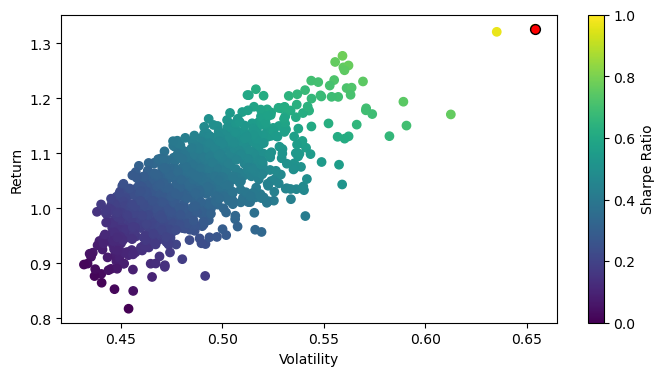

In [315]:
# plot the data
plt.figure(figsize=(8,4))
plt.scatter(volatility,returns_array,c=sharpe_ratio)
plt.scatter(volatility[sharpe_ratio.argmax()], returns_array[sharpe_ratio.argmax()], c='red', s=50, edgecolors='black')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

Using Optimization Algorithm to find the optimal weights for stocks giving highest Sharpe ratio

In [316]:
def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(port_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(port_returns.cov()*252,weights)))
    sr = (ret-(risk_free.mean()*252))/vol 
    return np.array([ret,vol,sr])

In [317]:
from scipy.optimize import minimize

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

In [318]:
# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [319]:
cons = ({'type':'eq','fun':check_sum})    # create constraint variable
bounds = tuple((0,1) for i in range(len(new_stocks)))    # create weight boundaries
init_guess = [1/len(new_stocks) for i in range(len(new_stocks))]    # initial guess

In [320]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [321]:
opt_results.x

array([0.        , 0.12406208, 0.15870236, 0.        , 0.        ,
       0.71723556])

In [438]:
opt_weights = np.round(opt_results.x,4)
indices=np.where(opt_weights > 0)[0].tolist()
print('Stocks : Weightage')
for i in indices:
    print(f'{port_returns.columns[i]}   : {opt_weights[i]}')

Stocks : Weightage
ENPH   : 0.1241
ETSY   : 0.1587
TSLA   : 0.7172


In [441]:
ret,vol,sr = get_ret_vol_sr(opt_results.x)
print(f'Returns: {ret}, Volatility: {vol}, Sharpe Ratio: {sr}')

Returns: 1.4271603018660244, Volatility: 0.6354653857446869, Sharpe Ratio: 1.3531961380435864


Here we can see that Tesla has the highest weightage among the portfolio, that is because it has the highest sharpe ratio i.e. it has the highest return per unit risk assumed. Now, we are going to perform price forecasting of highest sharpe ratio stock from each sector.

## Performing time series analysis on three stocks from three different sectors, having highest sharpe ratio in their respective sectors

In [324]:
#Function to plot the given stock data

def plot_stock(stock):
    plt.figure(figsize=(8, 4))
    plt.plot(stock)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'{stock.columns[0]} Stock')
    plt.show()

#### Dickey-Fuller test to detect stationarity

The null-hypothesis of ADF test is that stock data is not stationary. We are taking 0.05 as the significance level, if the p-value from test is below significance level, we can reject null-hypothesis and prove the stock data is stationary.

In [325]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(stock):
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(stock)
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    # print('ADF number of lags used:', usedlag)
    # print('ADF number of observations:', nobs)
    # print('ADF critical values:', crit_vals)
    # print('ADF best information criterion:', icbest)

#### Differencing method to remove stationarity from data

In [326]:
def differencing(stock):
    diff = stock.diff().dropna()
    return diff

An autocorrelation functions (ACF & PACF) to show graphical representation of the autocorrelation of a time series. 
We are using these to check correlation of a series with its lagged values.

In [327]:
#Function to plot acf of original stock_data and differenced data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def check_correlation(stock, diff):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    plot_acf(stock, lags=40, zero=False, ax=axes[0])
    axes[0].set_title('ACF for Original data')

    plot_acf(diff, lags=40, zero=False, ax=axes[1])
    axes[1].set_title('ACF for Differenced data')

    plot_pacf(diff, lags=40, zero=False, ax=axes[2])
    axes[2].set_title('PACF for Differenced data')

    plt.tight_layout()
    plt.show()

In [328]:
#Function to split data using train test split method

from sklearn.model_selection import train_test_split
def split_data(stock):
    train, test = train_test_split(stock, test_size=0.2, shuffle = False)
    return train, test

In [329]:
# Function to set start and end index used for predictions

def start_end(train,test):
    start = len(train)
    end = len(train) + len(test) - 1
    return start,end

#### Importing ARIMA and performing predictions stocks

In [330]:
from statsmodels.tsa.arima.model import ARIMA
def prediction(train,p,d,q,test):
    model = ARIMA(train, order =(p,d,q))
    result = model.fit()
    start, end = start_end(train,test)
    pred = result.predict(start, end)
    pred.index = test.index
    return pred

In [331]:
# Function to plot predicted data

def plot_pred(train,test,pred):
    plt.figure(figsize=(8, 4))
    plt.title('Predictions')
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(pred, label='Predictions')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

#### Importing performance metrics and evaluating performance of models

In [332]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def performance(test,pred):
    mae_ma = mean_absolute_error(test, pred)
    mse_ma = mean_squared_error(test, pred)
    rmse_ma = np.sqrt(mean_squared_error(test, pred))
    ma_perf = {'mae_ma': mae_ma, 'mse_ma': mse_ma,
    'rmse_ma': rmse_ma}
    ma_perf = pd.DataFrame([ma_perf])
    ma_perf
    return ma_perf

#### Performing forecast on stocks using ARIMA models

In [333]:
def forecast(test,diff,p,d,q):
    forecast_index = pd.date_range(test.index[-1], periods=10)
    model = ARIMA(diff, order =(p,d,q))
    result = model.fit()
    forecast = result.forecast(steps=10)
    forecast.index = forecast_index
    return forecast

In [334]:
# Function to plot forecasted data

def plot_forecast(diff,forecast):
    plt.figure(figsize=(8, 4))
    plt.title('Forecast')
    plt.plot(diff, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

### Performing Time series analysis for Enphase stock

In [335]:
enph_close = pd.DataFrame(IT_port['Close']['ENPH'])
enph_close.isna().sum()

ENPH    0
dtype: int64

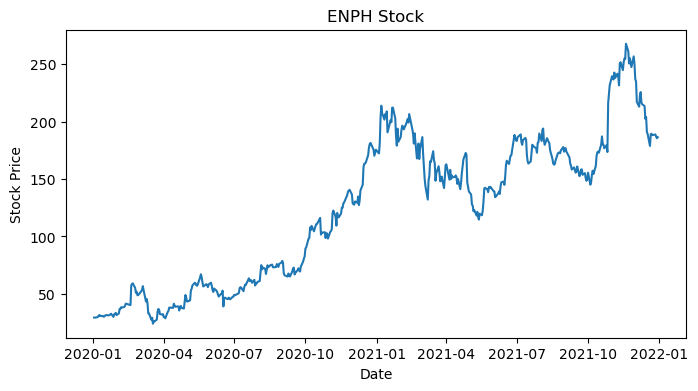

In [336]:
plot_stock(enph_close)

From above plot we can assume that data is not stationary, since there is a trend in the data. Performing ADF test to confirm the results.

In [337]:
test_stationarity(enph_close)

ADF test statistic: -1.3305314189669335
ADF p-values: 0.6150910107081653


The p-value is way higher than significance level supporting null hypothesis. This proves that the data is not stationary. Hence we need to perform differencing on the data to remove stationarity.

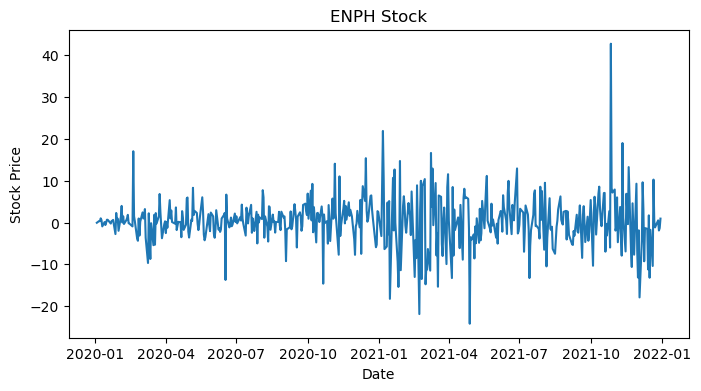

In [338]:
enph_diff = differencing(enph_close)
plot_stock(enph_diff)

In [339]:
test_stationarity(enph_diff)

ADF test statistic: -10.791039422129138
ADF p-values: 2.1328628963928038e-19


From the plot we can say that the data is stationary as there is no trend and mean seems to be constant over time. The same is confirmed with ADF test as p-value is less than 0.05.

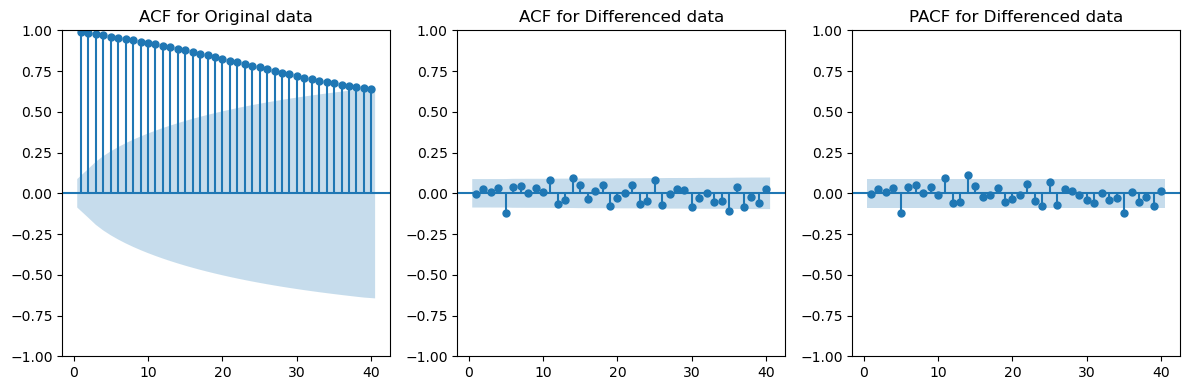

In [340]:
check_correlation(enph_close,enph_diff)

From the ACF and PACF we can see that most of the lag values are not statistically significant excluding few outliers, hence we can say that the differenced data has no autocorrelation. The lags $5^{th}$, $11^{th}$ and $14^{th}$ and some other lags have crossed significance level in ACF and PACF. Here we are taking $5^{th}$ lag as optimum lag for time series analysis. We are taking shorter lag to avoid complexity and overfitting.

#### Moving Average model

In [341]:
enph_ma_train,enph_ma_test = split_data(enph_diff)

enph_ma_pred = prediction(enph_ma_train,0,0,5,enph_ma_test)

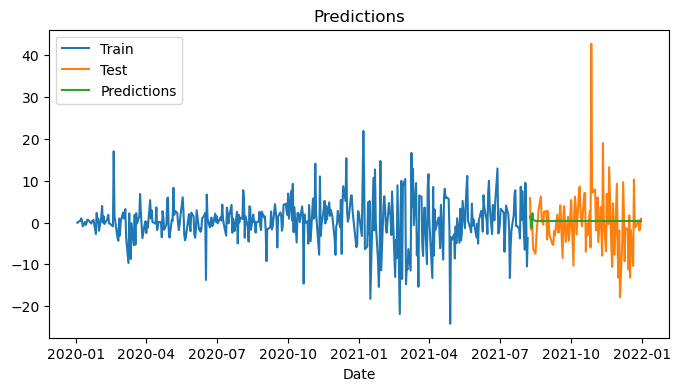

In [342]:
plot_pred(enph_ma_train,enph_ma_test,enph_ma_pred)

In [343]:
performance(enph_ma_test,enph_ma_pred)

,mae_ma,mse_ma,rmse_ma
0,4.99349,53.807096,7.335332


In [344]:
enph_ma_forecast = forecast(enph_ma_test,enph_diff,0,0,5)

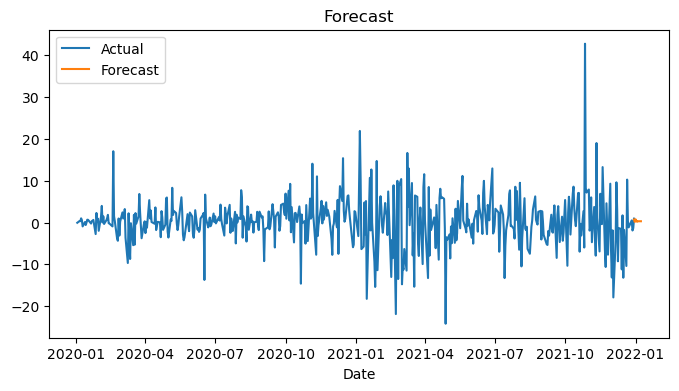

In [345]:
plot_forecast(enph_diff,enph_ma_forecast)

In [346]:
forecasted_date = enph_ma_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = enph_close['ENPH'].iloc[-1:][0] + enph_ma_forecast.sum()
print(f'The stock price of Enhpase on {forecasted_date} would be {forecasted_price} according to MA')

The stock price of Enhpase on 2022-01-08 would be 190.22085007362583 according to MA


The predicted stock price after 10 days is 190$. We are checking the same with other models as well.

#### AutoRegressive model

In [347]:
enph_ar_pred = prediction(enph_ma_train,5,0,0,enph_ma_test)

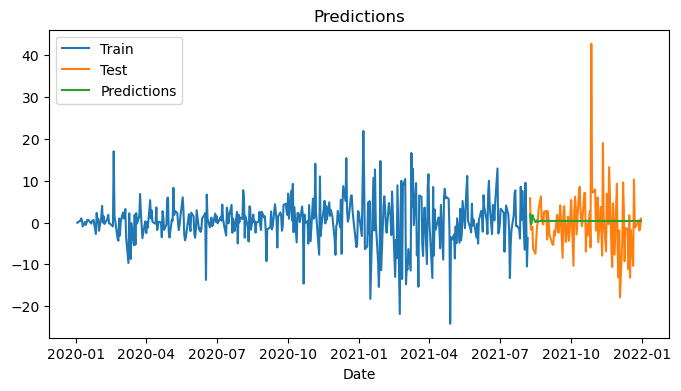

In [348]:
plot_pred(enph_ma_train,enph_ma_test,enph_ar_pred)

In [349]:
performance(enph_ma_test,enph_ar_pred)

,mae_ma,mse_ma,rmse_ma
0,4.990976,53.776703,7.33326


In [350]:
enph_ar_forecast = forecast(enph_ma_test,enph_diff,5,0,0)

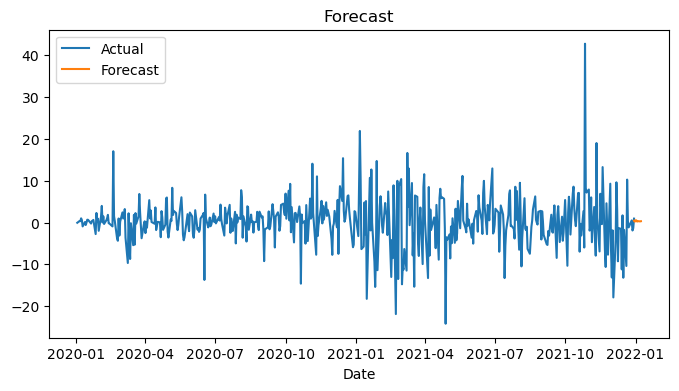

In [351]:
plot_forecast(enph_diff,enph_ar_forecast)

In [442]:
forecasted_date = enph_ar_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = enph_close['ENPH'].iloc[-1:][0] + enph_ar_forecast.sum()
print(f'The stock price of Enhpase on {forecasted_date} would be {forecasted_price} according to AR')

The stock price of Enhpase on 2022-01-08 would be 189.90527921354902 according to AR


#### ARIMA model

In [353]:
enph_arima_train,enph_arima_test = split_data(enph_close)

In [354]:
enph_arima_pred = prediction(enph_arima_train,5,1,5,enph_arima_test)

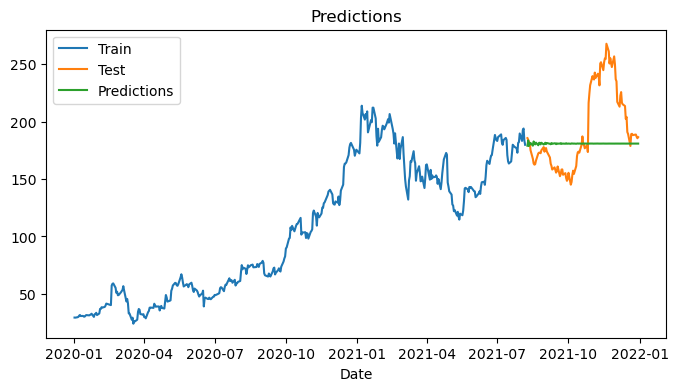

In [355]:
plot_pred(enph_arima_train,enph_arima_test,enph_arima_pred)

In [356]:
performance(enph_arima_test,enph_arima_pred)

,mae_ma,mse_ma,rmse_ma
0,28.285343,1358.686652,36.860367


In [357]:
enph_arima_forecast = forecast(enph_arima_test,enph_close,5,1,5)

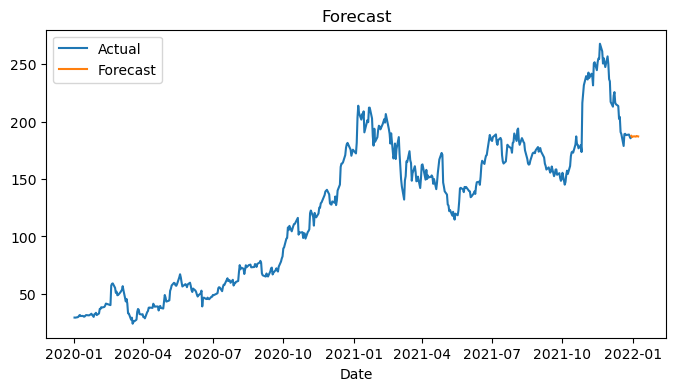

In [358]:
plot_forecast(enph_close,enph_arima_forecast)

In [359]:
forecasted_date = enph_arima_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = enph_arima_forecast.iloc[-1:][0]
print(f'The stock price of Enphase on {forecasted_date} would be {forecasted_price} according to ARIMA')

The stock price of Enphase on 2022-01-08 would be 187.02479047937507 according to ARIMA


### Performing Time series analysis for Tesla stock

In [360]:
tsla_close = pd.DataFrame(consum_port['Close']['TSLA'])
tsla_close.isna().sum()

TSLA    0
dtype: int64

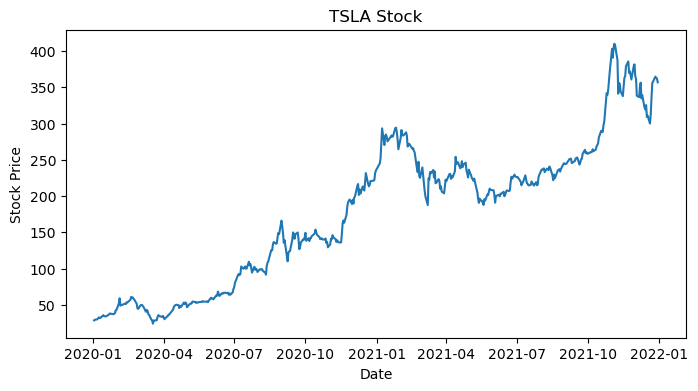

In [361]:
plot_stock(tsla_close)

In [362]:
test_stationarity(tsla_close)

ADF test statistic: -0.5790996817818587
ADF p-values: 0.8756350538794551


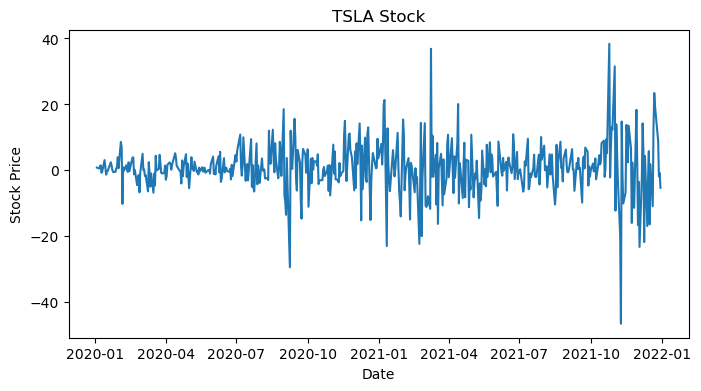

In [363]:
tsla_diff = differencing(tsla_close)
plot_stock(tsla_diff)

In [364]:
test_stationarity(tsla_diff)

ADF test statistic: -22.585748800972663
ADF p-values: 0.0


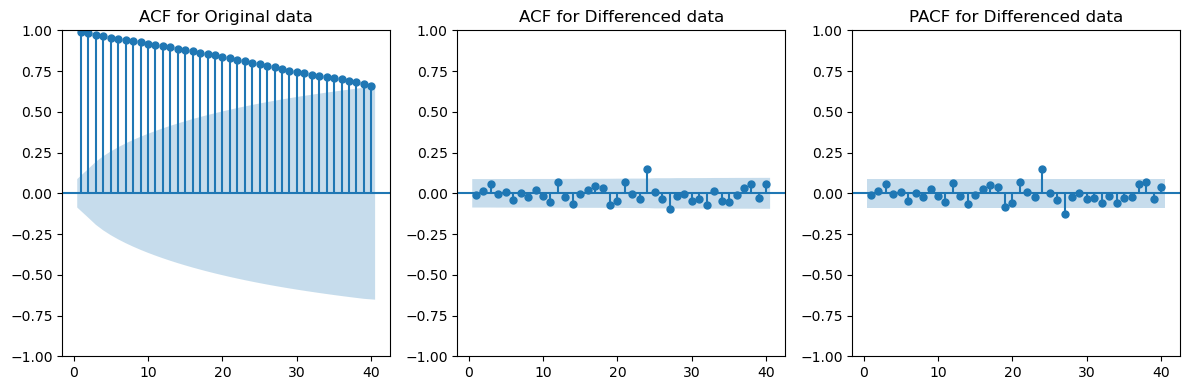

In [365]:
check_correlation(tsla_close,tsla_diff)

#### Moving Average model

In [366]:
tsla_ma_train,tsla_ma_test = split_data(tsla_diff)

tsla_ma_pred = prediction(tsla_ma_train,0,0,12,tsla_ma_test)

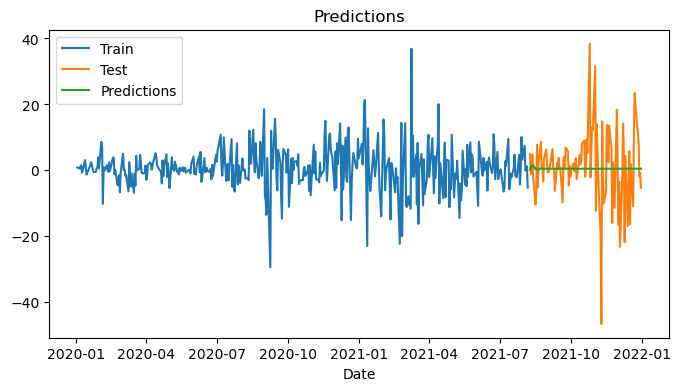

In [367]:
plot_pred(tsla_ma_train,tsla_ma_test,tsla_ma_pred)

In [368]:
performance(tsla_ma_test,tsla_ma_pred)

,mae_ma,mse_ma,rmse_ma
0,7.240154,117.769027,10.852144


In [369]:
tsla_ma_forecast = forecast(tsla_ma_test,tsla_diff,0,0,12)

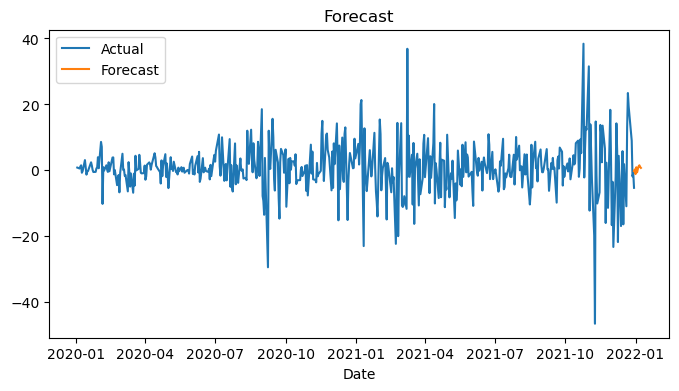

In [370]:
plot_forecast(tsla_diff,tsla_ma_forecast)

In [371]:
forecasted_date = tsla_ma_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = tsla_close['TSLA'].iloc[-1:][0] + tsla_ma_forecast.sum()
print(f'The stock price of Tesla on {forecasted_date} would be {forecasted_price} according to MA')

The stock price of Tesla on 2022-01-08 would be 360.99232565026296 according to MA


#### Autoregressive model

In [372]:
tsla_ar_pred = prediction(tsla_ma_train,12,0,0,tsla_ma_test)

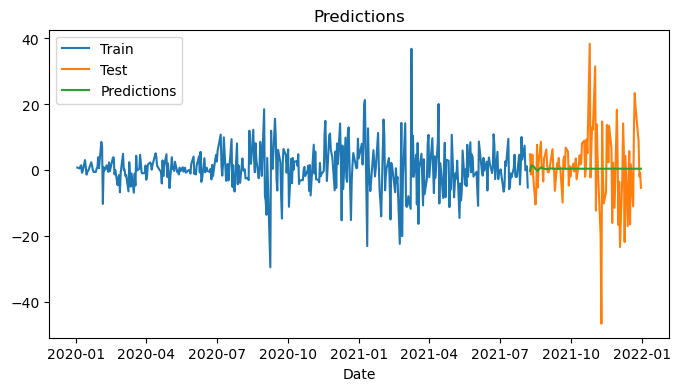

In [373]:
plot_pred(tsla_ma_train,tsla_ma_test,tsla_ar_pred)

In [374]:
performance(tsla_ma_test,tsla_ar_pred)

,mae_ma,mse_ma,rmse_ma
0,7.241188,117.76077,10.851763


In [375]:
tsla_ar_forecast = forecast(tsla_ma_test,tsla_diff,12,0,0)

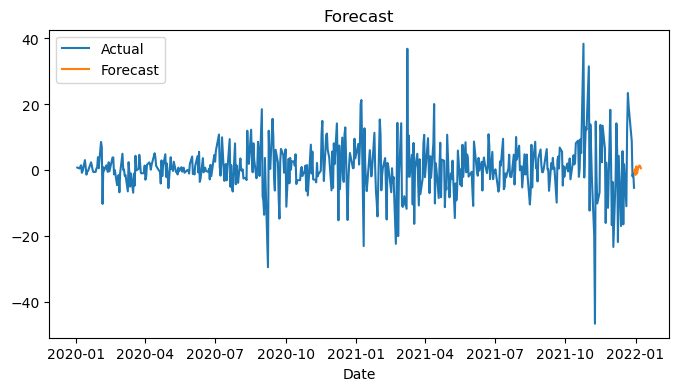

In [376]:
plot_forecast(tsla_diff,tsla_ar_forecast)

In [443]:
forecasted_date = tsla_ar_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = tsla_close['TSLA'].iloc[-1:][0] + tsla_ar_forecast.sum()
print(f'The stock price of Tesla on {forecasted_date} would be {forecasted_price} according to AR')

The stock price of Tesla on 2022-01-08 would be 360.5074224411094 according to AR


#### ARIMA model

In [378]:
tsla_arima_train,tsla_arima_test = split_data(tsla_close)
tsla_arima_pred = prediction(tsla_arima_train,12,1,12,tsla_arima_test)

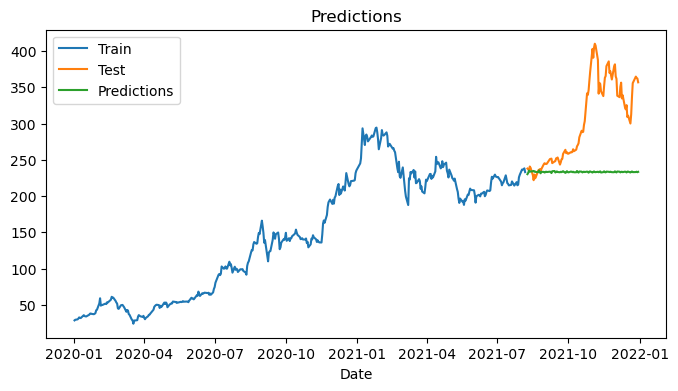

In [379]:
plot_pred(tsla_arima_train,tsla_arima_test,tsla_arima_pred)

In [380]:
performance(tsla_arima_test,tsla_arima_pred)

,mae_ma,mse_ma,rmse_ma
0,68.266929,7682.804384,87.651608


In [381]:
tsla_arima_forecast = forecast(tsla_arima_test,tsla_close,12,1,12)

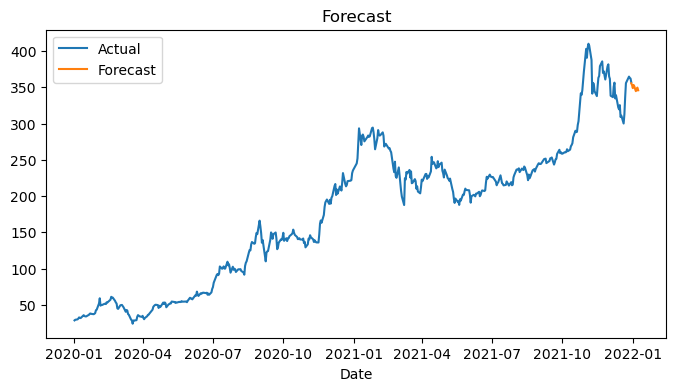

In [382]:
plot_forecast(tsla_close,tsla_arima_forecast)

In [383]:
forecasted_date = tsla_arima_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = tsla_arima_forecast.iloc[-1:][0]
print(f'The stock price of Tesla on {forecasted_date} would be {forecasted_price} according to ARIMA')

The stock price of Tesla on 2022-01-08 would be 345.7573387346963 according to ARIMA


### Performing Time series analysis for Freeport-McMoRan stock

In [384]:
fcx_close = pd.DataFrame(material_port['Close']['FCX'])
fcx_close.isna().sum()

FCX    0
dtype: int64

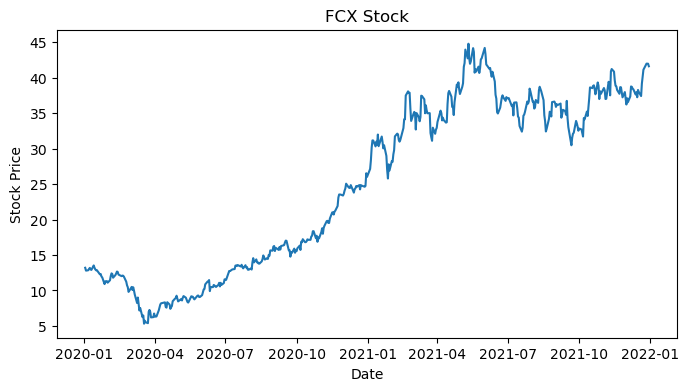

In [385]:
plot_stock(fcx_close)

In [386]:
test_stationarity(fcx_close)

ADF test statistic: -0.5042926668769546
ADF p-values: 0.8911760856151162


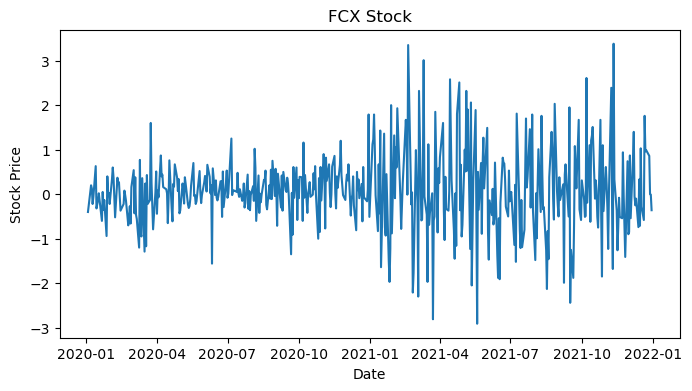

In [387]:
fcx_diff = differencing(fcx_close)
plot_stock(fcx_diff)

In [388]:
test_stationarity(fcx_diff)

ADF test statistic: -22.515735605014005
ADF p-values: 0.0


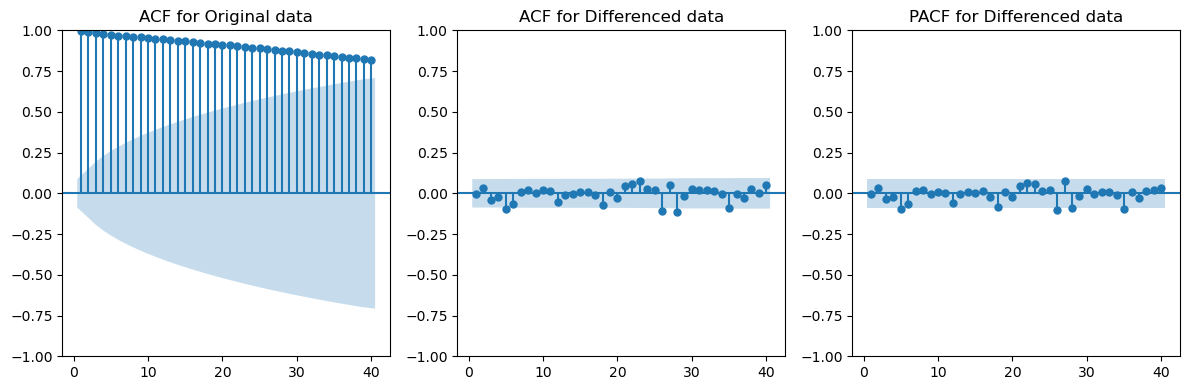

In [389]:
check_correlation(fcx_close,fcx_diff)

#### Moving average model

In [390]:
fcx_ma_train,fcx_ma_test = split_data(fcx_diff)
fcx_ma_pred = prediction(fcx_ma_train,0,0,6,fcx_ma_test)

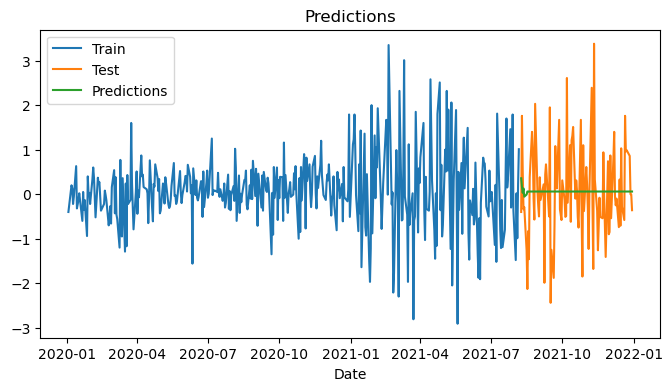

In [391]:
plot_pred(fcx_ma_train,fcx_ma_test,fcx_ma_pred)

In [392]:
performance(fcx_ma_test,fcx_ma_pred)

,mae_ma,mse_ma,rmse_ma
0,0.817011,1.098991,1.048328


In [393]:
fcx_ma_forecast = forecast(fcx_ma_test,fcx_diff,0,0,6)

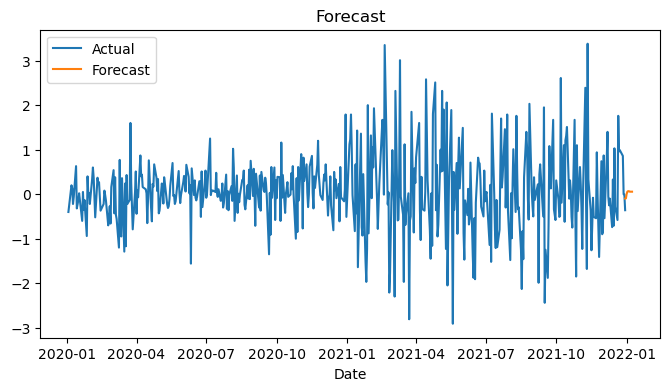

In [394]:
plot_forecast(fcx_diff,fcx_ma_forecast)

In [395]:
forecasted_date = fcx_ma_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = fcx_close['FCX'].iloc[-1:][0] + fcx_ma_forecast.sum()
print(f'The stock price of Freeport-McMoRan on {forecasted_date} would be {forecasted_price} according to MA')

The stock price of Freeport-McMoRan on 2022-01-08 would be 41.85744189959664 according to MA


#### Autoregressive model

In [396]:
fcx_ar_pred = prediction(fcx_ma_train,6,0,0,fcx_ma_test)

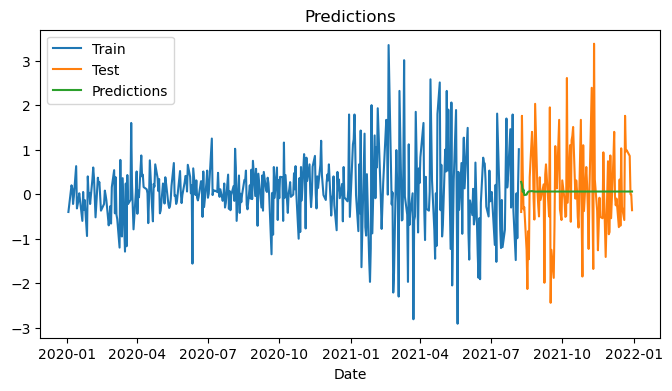

In [397]:
plot_pred(fcx_ma_train,fcx_ma_test,fcx_ar_pred)

In [398]:
performance(fcx_ma_test,fcx_ar_pred)

,mae_ma,mse_ma,rmse_ma
0,0.815084,1.094427,1.046149


In [399]:
fcx_ar_forecast = forecast(fcx_ma_test,fcx_diff,6,0,0)

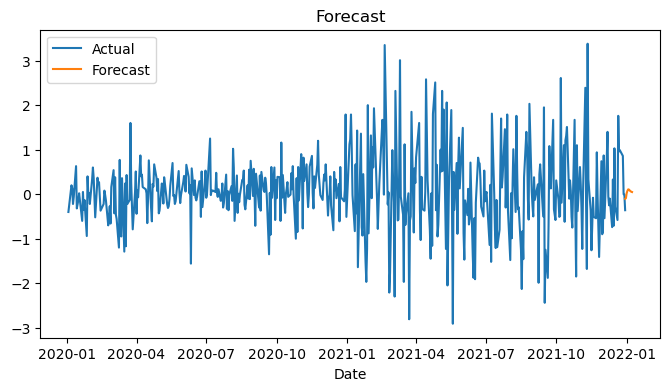

In [400]:
plot_forecast(fcx_diff,fcx_ar_forecast)

In [444]:
forecasted_date = fcx_ar_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = fcx_close['FCX'].iloc[-1:][0] + fcx_ar_forecast.sum()
print(f'The stock price of Freeport-McMoRan on {forecasted_date} would be {forecasted_price} according to AR')

The stock price of Freeport-McMoRan on 2022-01-08 would be 41.98985058907062 according to AR


#### ARIMA  model

In [402]:
fcx_arima_train,fcx_arima_test = split_data(fcx_close)
fcx_arima_pred = prediction(fcx_arima_train,6,1,6,fcx_arima_test)

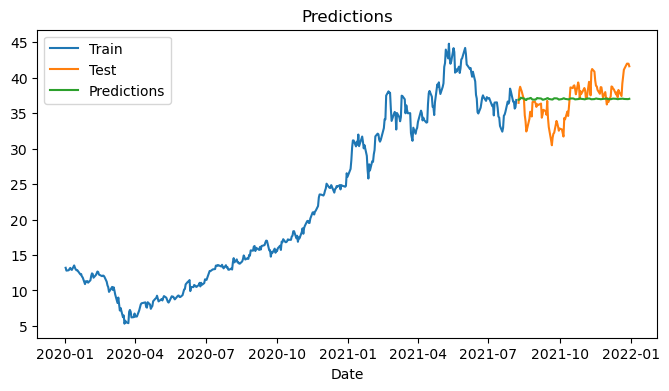

In [403]:
plot_pred(fcx_arima_train,fcx_arima_test,fcx_arima_pred)

In [404]:
performance(fcx_arima_test,fcx_arima_pred)

,mae_ma,mse_ma,rmse_ma
0,2.112878,6.98574,2.643055


In [405]:
fcx_arima_forecast = forecast(fcx_arima_test,fcx_close,6,1,6)

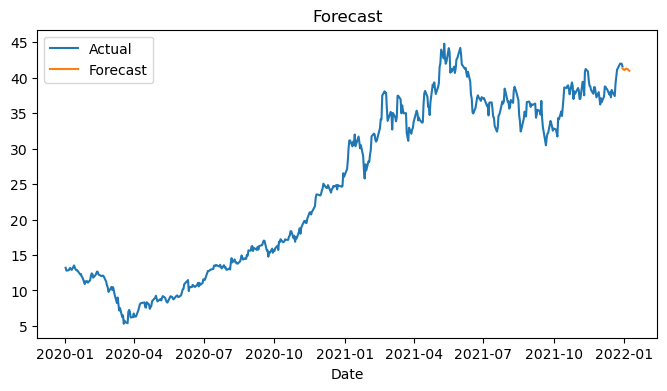

In [406]:
plot_forecast(fcx_close,fcx_arima_forecast)

In [407]:
forecasted_date = fcx_arima_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = fcx_arima_forecast.iloc[-1:][0]
print(f'The stock price of Freeport-McMoRan on {forecasted_date} would be {forecasted_price} according to ARIMA')

The stock price of Freeport-McMoRan on 2022-01-08 would be 40.98263696953908 according to ARIMA


### Multivariate time series analysis

In [408]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [409]:
def get_stock(stock):
    start = datetime.datetime(2020, 1, 1)
    end = datetime.datetime(2021, 12, 31)
    stock_data = yf.download(stock, start, end, interval='1d')
    X = stock_data[['Open', 'High', 'Low', 'Volume']]
    y = stock_data['Close']
    return X,y

In [410]:
def sarimax_pred(y_train,X_train,p,d,q,X_test):
    sarimax = SARIMAX(y_train, exog=X_train, order=(p,d,q))
    sarimax_result = sarimax.fit(disp=0)
    start,end = start_end(X_train,X_test)
    sarimax_pred = sarimax_result.predict(start, end, exog=X_test)
    sarimax_pred.index = X_test.index
    return sarimax_pred

In [411]:
def sarimax_forecast(y,X,p,d,q):
    sarimax = SARIMAX(y, exog=X, order=(p,d,q))
    sarimax_result = sarimax.fit(disp=0)
    sarimax_forecast = sarimax_result.forecast(steps=10, exog=X.iloc[-10:]) 
    forecast_index = pd.date_range(y.index[-1], periods=10) 
    sarimax_forecast.index = forecast_index
    return sarimax_forecast

### Performing multivariate analysis on enphase stock

In [412]:
enph_X,enph_y = get_stock('ENPH')

[*********************100%***********************]  1 of 1 completed


In [413]:
X_train,X_test = split_data(enph_X)

In [414]:
y_train,y_test = split_data(enph_y)

In [415]:
enph_sarimax_pred = sarimax_pred(y_train,X_train,5,1,5,X_test)

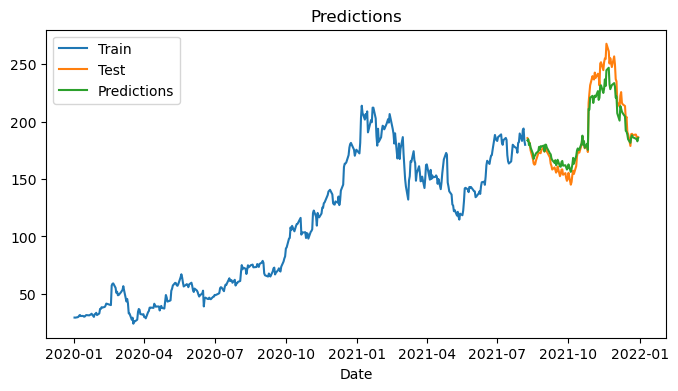

In [416]:
plot_pred(y_train,y_test,enph_sarimax_pred)

In [417]:
performance(y_test,enph_sarimax_pred)

,mae_ma,mse_ma,rmse_ma
0,8.593676,118.048134,10.864996


In [418]:
enph_sarimax_forecast = sarimax_forecast(enph_y,enph_X,5,1,5)

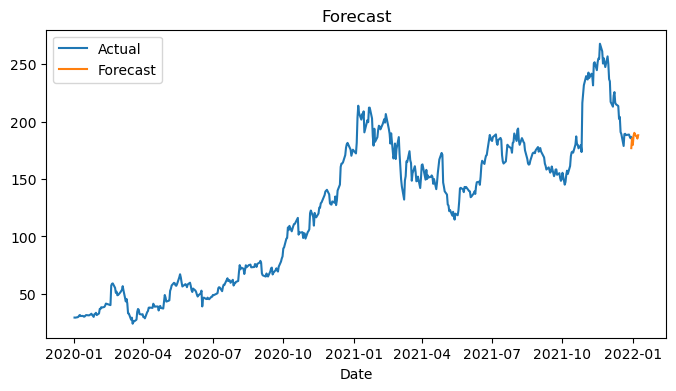

In [419]:
plot_forecast(enph_y,enph_sarimax_forecast)

In [420]:
forecasted_date = enph_sarimax_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = enph_sarimax_forecast.iloc[-1:][0]
print(f'The stock price of Enphase on {forecasted_date} would be {forecasted_price} according to SARIMAX')

The stock price of Enphase on 2022-01-08 would be 188.08416319062158 according to SARIMAX


### Performing multivariate analysis on Tesla

In [421]:
tsla_X,tsla_y = get_stock('TSLA')
X_train,X_test = split_data(tsla_X)
y_train,y_test = split_data(tsla_y)
tsla_sarimax_pred = sarimax_pred(y_train,X_train,6,1,6,X_test)

[*********************100%***********************]  1 of 1 completed


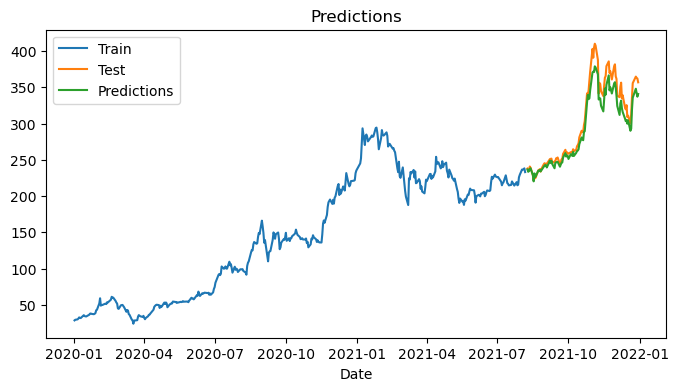

In [422]:
plot_pred(y_train,y_test,tsla_sarimax_pred)

In [423]:
performance(y_test,tsla_sarimax_pred)

,mae_ma,mse_ma,rmse_ma
0,11.477169,216.026622,14.697844


In [424]:
tsla_sarimax_forecast = sarimax_forecast(tsla_y,tsla_X,6,1,6)

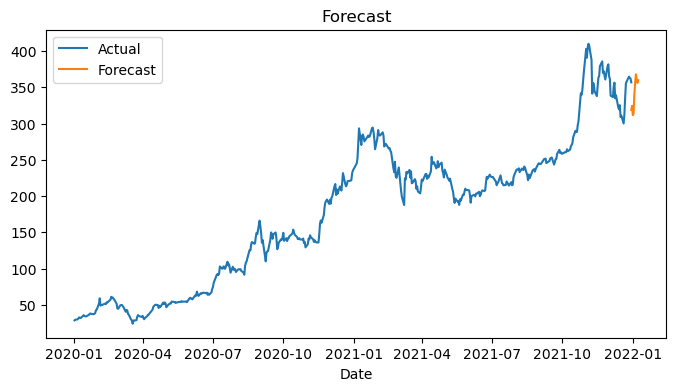

In [425]:
plot_forecast(tsla_y,tsla_sarimax_forecast)

In [426]:
forecasted_date = tsla_sarimax_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = tsla_sarimax_forecast.iloc[-1:][0]
print(f'The stock price of Tesla on {forecasted_date} would be {forecasted_price} according to SARIMAX')

The stock price of Tesla on 2022-01-08 would be 359.7759521777977 according to SARIMAX


### Performing multivariate analysis on Freeport-McMoRan

In [427]:
fcx_X,fcx_y = get_stock('FCX')
X_train,X_test = split_data(fcx_X)
y_train,y_test = split_data(fcx_y)
fcx_sarimax_pred = sarimax_pred(y_train,X_train,5,1,5,X_test)

[*********************100%***********************]  1 of 1 completed


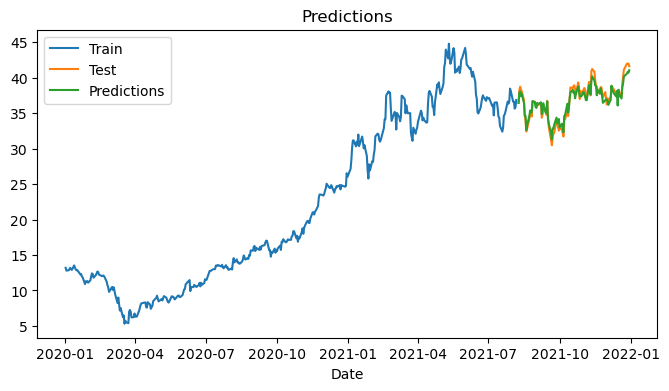

In [428]:
plot_pred(y_train,y_test,fcx_sarimax_pred)

In [429]:
performance(y_test,fcx_sarimax_pred)

,mae_ma,mse_ma,rmse_ma
0,0.541451,0.452401,0.672608


In [430]:
fcx_sarimax_forecast = sarimax_forecast(fcx_y,fcx_X,6,1,6)

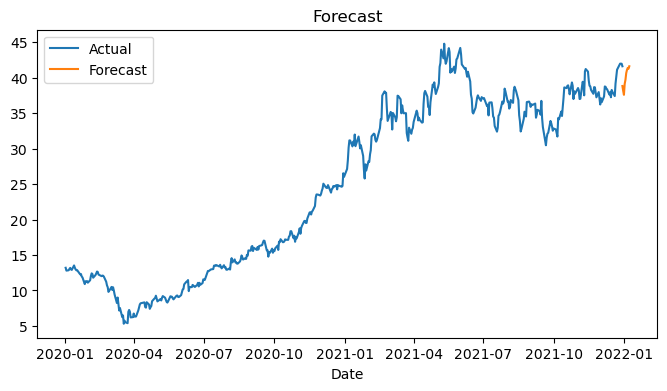

In [431]:
plot_forecast(fcx_y,fcx_sarimax_forecast)

In [432]:
forecasted_date = fcx_sarimax_forecast.index[-1:][0].date()  #last forecasted date
forecasted_price = fcx_sarimax_forecast.iloc[-1:][0]
print(f'The stock price of Freeport-McMoRan on {forecasted_date} would be {forecasted_price} according to SARIMAX')

The stock price of Freeport-McMoRan on 2022-01-08 would be 41.619998931884766 according to SARIMAX
